In [5]:
from __future__ import print_function
import numpy as np
import os, time, json
from os.path import exists, join
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor

from PIL import Image
import requests
import torch
from torch.utils.data import DataLoader, Dataset
from dataset import LSUN_CAT

2023-04-30 10:02:36.036764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.makedirs("./data/images/", exist_ok=True)
os.makedirs("./data/masks/", exist_ok=True)
db_path = "./data/cat/"

In [6]:
# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
processor = Mask2FormerImageProcessor(True, (384, 384))
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

In [13]:

# img = view(db_path, idx=2)
# img_2 = view(db_path, idx=1)
# img = Image.fromarray(img)
# print(img.size)

# img_list = [img, img_2]

Viewing ./data/cat/
Press ESC to exist or SPACE to advance.
Current key: b'017217f0d99061b6e736f97fcc4492954757f895'
Current key: b'017222a04eaa2b774bab0e4459d9bb88625e3ffa'
Current key: b'01722429e60bd145df085532f3f43162cf36b447'
Viewing ./data/cat/
Press ESC to exist or SPACE to advance.
Current key: b'017217f0d99061b6e736f97fcc4492954757f895'
Current key: b'017222a04eaa2b774bab0e4459d9bb88625e3ffa'
(350, 310)


In [44]:
img_folder = "./data/images/"
img_list = []
img_names = os.listdir(img_folder)
for file in os.listdir(img_folder)[:32]:
    img_list.append(Image.open(join(img_folder, file)).convert("RGB"))

In [22]:
inputs = processor(images=img_list, return_tensors="pt")
for k,v in inputs.items():
    print(k,v.shape)
inputs["pixel_values"] = inputs["pixel_values"].to(device)
inputs["pixel_mask"] = inputs["pixel_mask"].to(device)
model = model.to(device)
batch_shape = inputs["pixel_values"].shape
batch_shape

pixel_values torch.Size([32, 3, 384, 384])
pixel_mask torch.Size([32, 384, 384])


torch.Size([32, 3, 384, 384])

In [24]:
st_time = time.time()
with torch.no_grad():
  outputs = model(**inputs)
print(f"Forward Pass with {batch_shape} takes {time.time()-st_time}s")

Forward Pass with torch.Size([32, 3, 384, 384]) takes 0.5790467262268066s


In [25]:
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[(224, 224) for i in range(len(img_list))])
print(results[0].keys())

`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


In [26]:
segment_to_label = {segment['id']: segment['label_id'] for segment in results[0]["segments_info"]}
print(segment_to_label)

{1: 15, 2: 132, 3: 122}


In [43]:
results[5]

{'segmentation': tensor([[6, 6, 6,  ..., 6, 6, 6],
         [6, 6, 6,  ..., 6, 6, 6],
         [6, 6, 6,  ..., 6, 6, 6],
         ...,
         [6, 6, 6,  ..., 6, 6, 6],
         [6, 6, 6,  ..., 6, 6, 6],
         [6, 6, 6,  ..., 6, 6, 6]], device='cuda:0', dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 15,
   'was_fused': False,
   'score': 0.58943},
  {'id': 2, 'label_id': 47, 'was_fused': False, 'score': 0.942347},
  {'id': 3, 'label_id': 15, 'was_fused': False, 'score': 0.860112},
  {'id': 4, 'label_id': 15, 'was_fused': False, 'score': 0.8036},
  {'id': 5, 'label_id': 47, 'was_fused': False, 'score': 0.694679},
  {'id': 6, 'label_id': 131, 'was_fused': False, 'score': 0.608482}]}

In [7]:
ds = LSUN_CAT("./data/images/")
loader = DataLoader(ds, batch_size=32, shuffle=False)

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [26]:
test = next(iter(loader))[0]

In [9]:
for i, (x, paths) in enumerate(loader):
    x["pixel_values"] = x["pixel_values"][0].to(device)
    x["pixel_mask"] = x["pixel_mask"][0].to(device)
    
    model = model.to(device)
    st_time = time.time()
    with torch.no_grad():
        outputs = model(**x)
    print(f"Forward Pass with Batch {i+1} takes {time.time()-st_time}s")

    break

Forward Pass with Batch 1 takes 1.6411592960357666s


In [25]:
from datetime import datetime
import logging

cur_time = datetime.now()
log_dir = f"./logs/{cur_time.month}-{cur_time.day}-{cur_time.hour}-{cur_time.minute}/"
os.makedirs(log_dir, exist_ok=True)

# Store data
os.makedirs("./data/masks/", exist_ok=True)

log_file = log_dir + "/log_file.log"
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s %(levelname)-8s %(message)s")
console.setFormatter(formatter)
logging.getLogger("").addHandler(console)

In [20]:
def get_mask(segment_id):
  print("Visualizing mask for:", model.config.id2label[segment_to_label[segment_id]])
  mask = (results['segmentation'].numpy() == segment_id)
  return mask



In [19]:
target_dir = os.path.join("./data/masks", "test")
target_dir

'./data/masks/test'

'1a54aef8172c853a947959a05c68556d42be4912'

In [23]:
def create_dir(filename, mask_dir="./data/masks/"):
    # exclude the extension
    dir_name = filename[:-4]
    target_dir = os.path.join(mask_dir, dir_name)
    os.makedirs(target_dir, exist_ok=True)
    return target_dir

def save_mask_img(mask_list:list, id_list, out_dir:str):
    for mask, id in zip(mask_list, id_list):
        out_file = os.path.join(out_dir, f"{id}.png")
        im = Image.fromarray(mask)
        im.save(out_file)
    return

def save_segments_np(seg_tensor:torch.Tensor, out_dir:str):
    seg_np = seg_tensor.cpu().numpy()
    out_path = os.path.join(out_dir, "segments.npy")
    np.save(out_path, seg_np)
    return

def save_segments_info(segments_info:list, out_dir:str):
    """
    Input:
        segments_info: (e.g. [{'id': 1, 'label_id': 15, 'was_fused': False, 'score': 0.999431}, {'id': 2, 'label_id': 132, 'was_fused': False, 'score': 0.930572}, {'id': 3, 'label_id': 122, 'was_fused': False, 'score': 0.910661}])
    """
    if type(segments_info) != list:
        raise SyntaxError
    out_path = os.path.join(out_dir, "segments_info.json")
    with open(out_path, 'w') as f:
        json.dump(segments_info, f)
    return

def get_vis_masks(results, labels=["dog", "cat", "kitten", "monkey"]) -> list:
    """
    Input:
        results (dict): {segmentation: tensor, segments_info: list}
        labels (list): the labels that we want to save
    """
    mask_list = []
    seg_id_list = []
    segment_to_label = {segment['id']: segment['label_id'] for segment in results["segments_info"]}
    
    for segment in results["segments_info"]:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        # if model.config.id2label[segment_to_label[segment_id]] == label:
        #   mask += (results['segmentation'].numpy() == segment_id)
        # visual_mask = np.clip((mask * 255).astype(np.uint8), None, 255)
        # visual_mask = Image.fromarray(visual_mask)
        # if model.config.id2label[segment_to_label[segment_id]] in labels:
        if segment["score"] >= 0.7 and model.config.id2label[segment_to_label[segment_id]] in labels:
            mask = (results['segmentation'].cpu().numpy() == segment_id)
            mask = (mask * 255).astype(np.uint8)
            seg_id_list.append(segment_id)
            mask_list.append(mask)
    return mask_list, seg_id_list


def saving_masks(outputs, files, target_size=(384, 384)):
    results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[target_size for i in range(len(files))])
    for result, file in zip(results, files):
        out_dir = create_dir(file)
        mask_list, id_list = get_vis_masks(result)
        save_segments_np(result["segmentation"], out_dir)
        save_segments_info(result["segments_info"], out_dir)
        save_mask_img(mask_list, id_list, out_dir)
    return

In [26]:
for i, (x, files) in enumerate(loader):
    logging.info(f"---Batch {i}---")
    x["pixel_values"] = x["pixel_values"][0].to(device)
    x["pixel_mask"] = x["pixel_mask"][0].to(device)
    
    model = model.to(device)
    st_time = time.time()
    with torch.no_grad():
        outputs = model(**x)
    logging.info(f"Forward Pass with Batch {i+1} takes {time.time()-st_time}s")
    
    logging.info(f"Saving the masks")

    # results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[(224, 224) for i in range(len(img_list))])
    # saving_masks(outputs, paths)
    saving_masks(outputs, files, target_size=(384, 384))
    break

2023-04-30 09:54:09,521 INFO     ---Batch 0---
2023-04-30 09:54:10,132 INFO     Forward Pass with Batch 1 takes 0.5717334747314453s
2023-04-30 09:54:10,133 INFO     Saving the masks
`label_ids_to_fuse` unset. No instance will be fused.
2023-04-30 09:54:10,188 INFO     ---saving segmentation matrix---
2023-04-30 09:54:10,190 INFO     ---saving segmentation information---
2023-04-30 09:54:10,192 INFO     ---saving mask images
2023-04-30 09:54:10,196 INFO     ---saving segmentation matrix---
2023-04-30 09:54:10,198 INFO     ---saving segmentation information---
2023-04-30 09:54:10,200 INFO     ---saving mask images
2023-04-30 09:54:10,204 INFO     ---saving segmentation matrix---
2023-04-30 09:54:10,206 INFO     ---saving segmentation information---
2023-04-30 09:54:10,207 INFO     ---saving mask images
2023-04-30 09:54:10,210 INFO     ---saving segmentation matrix---
2023-04-30 09:54:10,212 INFO     ---saving segmentation information---
2023-04-30 09:54:10,213 INFO     ---saving mask ima

In [10]:
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[(384, 384) for i in range(32)])
print(results[0].keys())

`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


In [116]:
for i, result in enumerate(results):
    print(result["segments_info"])
    segment_to_label = {segment['id']: segment['label_id'] for segment in result["segments_info"]}
    print(segment_to_label)

[{'id': 1, 'label_id': 15, 'was_fused': False, 'score': 0.999431}, {'id': 2, 'label_id': 132, 'was_fused': False, 'score': 0.930572}, {'id': 3, 'label_id': 122, 'was_fused': False, 'score': 0.910661}]
{1: 15, 2: 132, 3: 122}
[{'id': 1, 'label_id': 15, 'was_fused': False, 'score': 0.9989}, {'id': 2, 'label_id': 15, 'was_fused': False, 'score': 0.992893}, {'id': 3, 'label_id': 87, 'was_fused': False, 'score': 0.995298}, {'id': 4, 'label_id': 108, 'was_fused': False, 'score': 0.89581}, {'id': 5, 'label_id': 72, 'was_fused': False, 'score': 0.757494}, {'id': 6, 'label_id': 73, 'was_fused': False, 'score': 0.837134}, {'id': 7, 'label_id': 120, 'was_fused': False, 'score': 0.905626}, {'id': 8, 'label_id': 28, 'was_fused': False, 'score': 0.997846}, {'id': 9, 'label_id': 104, 'was_fused': False, 'score': 0.820482}, {'id': 10, 'label_id': 131, 'was_fused': False, 'score': 0.99022}]
{1: 15, 2: 15, 3: 87, 4: 108, 5: 72, 6: 73, 7: 120, 8: 28, 9: 104, 10: 131}
[{'id': 1, 'label_id': 0, 'was_fused'

In [106]:
mask_list = get_vis_masks(results[17])

{1: 15, 2: 128, 3: 131}


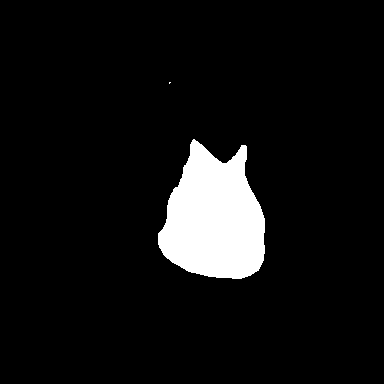

In [112]:
for mask in mask_list:
    im = Image.fromarray(mask)
    im.show()

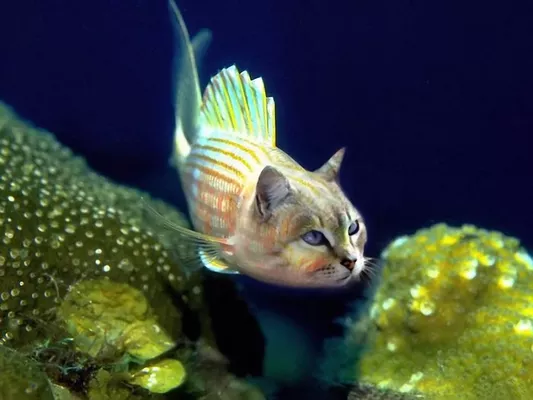

In [109]:
img_list[17].show()